In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from interpolatingness import *
from reverseEngineerNetwork import *
from flatness import *

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
rng = np.random.default_rng(7)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Approximating the Generalization Bound

We approximate representativeness via the error of a KDE in feature space. We then compute the proposed relative flatness measure to compute an approximate generalization bound. We also evaluate the train and test error to estimate the generalization gap. 

In [19]:
def mean_squared_error(y_true, y_pred):
    return ((y_true - y_pred)**2).mean(axis=0)

def computeGenBoundandGenError(X_train, y_train, X_test, y_test, loss, delta, getRevModel, useVariableKDE = True, returnIndLosses = False):
    n,m = X_train.shape
    
    psi = RidgeClassifier()
    psi.fit(X_train, y_train)
    RepApprox = approximateIntViaVKDE(X_train, y_train, None, 0.01, mean_squared_error, useVariableKDE = useVariableKDE)
    
    
    f, phi = getRevModel(psi)
    origX_train = reverseModelPropagation(phi, X_train)
    origX_test  = reverseModelPropagation(phi, X_test)

    Ktr, Klmbda, _, _, test_loss, train_loss = computeFlatnessMeasure(f, origX_train, y_train, origX_test, y_test)
    
    eps = (delta**2/m) * Ktr
    
    
    genBound = eps+RepApprox
    genGap   = test_loss-train_loss
    if returnIndLosses:
        return genBound, genGap, train_loss, test_loss
    return genBound, genGap

def evaluateGenBoundAndGenGap_inverseCV(Xphi, y, loss, delta, cv = 10, useVariableKDE = True, returnIndLosses = False, trainingDataMax = -1, getRevModel = getReverseEngineeredModel_ridge):
    if cv is None or cv == 0:
        cv = 1
    n,m = Xphi.shape
    
    genBounds, genGaps = [], []    
    trainLosses, testLosses = [], []
    idxs = np.arange(n)
    RNG.shuffle(idxs)
    foldIdxs = np.array_split(idxs, cv)
    for i in range(cv):
        Testidx = np.concatenate([foldIdxs[j] for j in range(cv) if j != i])
        Trainidx  = foldIdxs[i]
        if trainingDataMax > 0:
            Trainidx = Trainidx[:trainingDataMax]
        X_train, y_train, X_test, y_test =  Xphi[Trainidx], y[Trainidx], Xphi[Testidx], y[Testidx]
        genBound, genGap, train_loss, test_loss = computeGenBoundandGenError(X_train, y_train, X_test, y_test, mean_squared_error, 0.1, getRevModel, returnIndLosses = True)
        genBounds.append(genBound)
        genGaps.append(genGap)
        trainLosses.append(train_loss)
        testLosses.append(test_loss)
    avgGenBound = sum(genBounds) / len(genBounds)
    avgGenGap = sum(genGaps) / len(genGaps)
    if returnIndLosses:
        return avgGenBound, avgGenGap, genBounds, genGaps, trainLosses, testLosses
    return avgGenBound, avgGenGap, genBounds, genGaps

# Computing the Approximate Generalization Bound and Generalization Gap

In [27]:
n = 600
delta = 0.1

classSeps = [0.5,0.8,1.0,1.5,2.0,3.0, 4.0, 5.0]
Gaps, Bounds, avgGaps, avgBounds = [], [], [], []
trainLosses, testLosses, avgTrainLosses, avgTestLosses = [], [], [], []
for sep in classSeps:
    Xphi, y = make_classification(n_samples=n, n_features=10, n_informative=3, n_redundant=4, class_sep = sep)   
    avgGenBound, avgGenGap, genBounds, genGaps, trainLoss, testLoss = evaluateGenBoundAndGenGap_inverseCV(Xphi, y, mean_squared_error, delta, cv= 3, returnIndLosses = True, trainingDataMax = 50)
    trainLosses.append(trainLoss)
    testLosses.append(testLoss)
    avgTrainLosses.append(np.mean(trainLoss))
    avgTestLosses.append(np.mean(testLoss))
    Gaps.append(genGaps)
    Bounds.append(genBounds)
    avgGaps.append(avgGenGap)
    avgBounds.append(avgGenBound)

# Plotting the Results

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


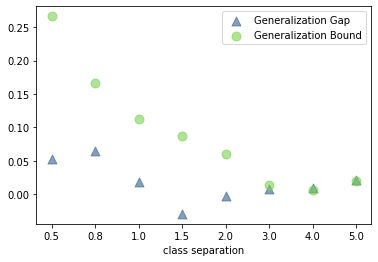

In [28]:
cmap = cm.get_cmap("viridis")
plt.scatter(range(len(classSeps)), avgGaps, label="Generalization Gap", alpha=0.6, marker='^', s=80, c=cmap(0.3))
plt.scatter(range(len(classSeps)), avgBounds, label="Generalization Bound", alpha=0.6, s=80, c=cmap(0.8))
#plt.scatter(range(len(classSeps)), avgTrainLosses5, label="Train Loss")
#plt.scatter(range(len(classSeps)), avgTestLosses5, label="Test Loss")

ax = plt.gca()
ax.set_xticks(range(len(classSeps)))
ax.set_xticklabels(classSeps)
plt.xlabel(r"class separation")
plt.legend()
plt.savefig("genBoundApprox.pdf")
plt.show()

# Use a different architecture

In [109]:
rng = np.random.default_rng(15)

n = 600
delta = 0.1

classSeps = [0.5,0.8,1.0,1.5,2.0,3.0, 4.0, 5.0]
Gaps, Bounds, avgGaps, avgBounds = [], [], [], []
trainLosses, testLosses, avgTrainLosses, avgTestLosses = [], [], [], []
for sep in classSeps:
    Xphi, y = make_classification(n_samples=n, n_features=10, n_informative=3, n_redundant=4, class_sep = sep)   
    avgGenBound, avgGenGap, genBounds, genGaps, trainLoss, testLoss = evaluateGenBoundAndGenGap_inverseCV(Xphi, y, mean_squared_error, delta, cv= 10, returnIndLosses = True, trainingDataMax = 50, getRevModel = getReverseEngineeredModel_DeepRidge)
    trainLosses.append(trainLoss)
    testLosses.append(testLoss)
    avgTrainLosses.append(np.mean(trainLoss))
    avgTestLosses.append(np.mean(testLoss))
    Gaps.append(genGaps)
    Bounds.append(genBounds)
    avgGaps.append(avgGenGap)
    avgBounds.append(avgGenBound)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


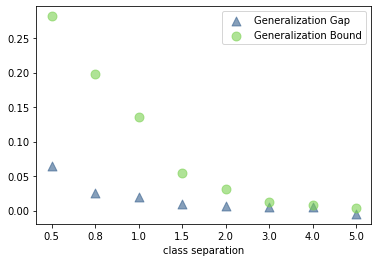

In [110]:
cmap = cm.get_cmap("viridis")
plt.scatter(range(len(classSeps)), avgGaps, label="Generalization Gap", alpha=0.6, marker='^', s=80, c=cmap(0.3))
plt.scatter(range(len(classSeps)), avgBounds, label="Generalization Bound", alpha=0.6, s=80, c=cmap(0.8))
#plt.scatter(range(len(classSeps)), avgTrainLosses5, label="Train Loss")
#plt.scatter(range(len(classSeps)), avgTestLosses5, label="Test Loss")

ax = plt.gca()
ax.set_xticks(range(len(classSeps)))
ax.set_xticklabels(classSeps)
plt.xlabel(r"class separation")
plt.legend()
plt.savefig("genBoundApproxDeep.pdf")
plt.show()

# Lastly, let's take a different dataset

In [82]:
rng = np.random.default_rng(6)

n = 600
delta = 0.1

classSeps = [0.5,0.8,1.0,1.5,2.0,3.0, 4.0, 5.0]
Gaps, Bounds, avgGaps, avgBounds = [], [], [], []
trainLosses, testLosses, avgTrainLosses, avgTestLosses = [], [], [], []
for sep in classSeps:
    Xphi, y = make_classification(n_samples=n, n_features=16, n_informative=3, n_redundant=4, n_clusters_per_class = 3, class_sep = sep)   
    avgGenBound, avgGenGap, genBounds, genGaps, trainLoss, testLoss = evaluateGenBoundAndGenGap_inverseCV(Xphi, y, mean_squared_error, delta, cv= 10, returnIndLosses = True, trainingDataMax = 50, getRevModel = getReverseEngineeredModel_DeepRidge)
    trainLosses.append(trainLoss)
    testLosses.append(testLoss)
    avgTrainLosses.append(np.mean(trainLoss))
    avgTestLosses.append(np.mean(testLoss))
    Gaps.append(genGaps)
    Bounds.append(genBounds)
    avgGaps.append(avgGenGap)
    avgBounds.append(avgGenBound)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


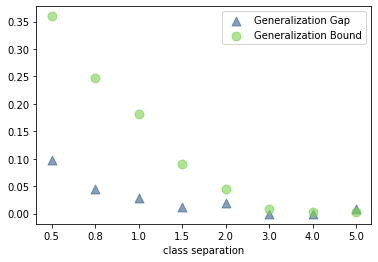

In [84]:
cmap = cm.get_cmap("viridis")
plt.scatter(range(len(classSeps)), avgGaps, label="Generalization Gap", alpha=0.6, marker='^', s=80, c=cmap(0.3))
plt.scatter(range(len(classSeps)), avgBounds, label="Generalization Bound", alpha=0.6, s=80, c=cmap(0.8))
#plt.scatter(range(len(classSeps)), avgTrainLosses5, label="Train Loss")
#plt.scatter(range(len(classSeps)), avgTestLosses5, label="Test Loss")

ax = plt.gca()
ax.set_xticks(range(len(classSeps)))
ax.set_xticklabels(classSeps)
plt.xlabel(r"class separation")
plt.legend()
plt.savefig("genBoundApproxHardData.pdf")
plt.show()